# Git session initialization

###Purge APS360 Folder if needed

In [20]:
%cd /content/
!rm -rf APS360

/content


###Init

In [77]:
%cd /content/
!git --version
!git config --global user.email “thesirpotato514@gmail.com”
!git config --global user.name “louis zhu”

%cd APS360
!git pull origin main

/content
git version 2.34.1
/content/APS360
From https://github.com/zehuasong/APS360
 * branch            main       -> FETCH_HEAD
Already up to date.


# Primary Model

###Segmentation

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_segmentation(img):
    # 2) Threshold & Invert (so brackets/digits become white on black)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3) (Optional) Morphological Opening to remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 4) Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bracket_contours = []
    other_contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        # Heuristic filters for bracket detection:
        # - Brackets might be tall and relatively thin (or short and wide)
        # - Adjust these thresholds to match your images
        aspect_ratio = w / float(h + 1e-5)  # avoid division by zero
        if area > 31000 and (0.1 < aspect_ratio < 0.4 or 2.5 < aspect_ratio < 10):
            # This is likely a bracket (depending on orientation).
            bracket_contours.append((cnt, x, y, w, h))
        else:
            # Might be digits or noise
            other_contours.append((cnt, x, y, w, h))

    # Sort bracket contours from left to right based on x
    bracket_contours.sort(key=lambda bc: bc[1])

    # For a 2×2 matrix side by side, you might expect 4 brackets total (2 for left matrix, 2 for right matrix).
    # bracket_contours = [ (cnt, x, y, w, h), ... ] sorted by x
    print(f"Found {len(bracket_contours)} potential bracket(s).")

    # Just for visualization: draw bracket bounding boxes on a copy of the image
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for i, (cnt, x, y, w, h) in enumerate(bracket_contours):
        cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(img_color, f"B{i}", (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_color[:,:,::-1])  # BGR -> RGB
    plt.title("Detected Brackets (Bounding Boxes)")
    plt.axis('off')
    plt.show()

    ###############################
    # 5) USE BRACKETS TO SEPARATE #
    ###############################
    # Example approach:
    # - Suppose bracket_contours[0] is the left bracket of the first matrix
    # - bracket_contours[1] is the right bracket of the first matrix
    # - bracket_contours[2] is the left bracket of the second matrix
    # - bracket_contours[3] is the right bracket of the second matrix

    if len(bracket_contours) >= 4:
        # Extract bounding boxes for the two matrix regions:
        # We'll define each matrix region from the right edge of its left bracket
        # to the left edge of its right bracket
        _, x1, y1, w1, h1 = bracket_contours[0]  # left bracket (matrix 1)
        _, x2, y2, w2, h2 = bracket_contours[1]  # right bracket (matrix 1)

        matrix1_left = x1 + w1
        matrix1_right = x2
        matrix1_top = min(y1, y2)
        matrix1_bottom = max(y1 + h1, y2 + h2)

        # Crop out the first matrix
        matrix1 = thresh[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]

        _, x3, y3, w3, h3 = bracket_contours[2]  # left bracket (matrix 2)
        _, x4, y4, w4, h4 = bracket_contours[3]  # right bracket (matrix 2)

        matrix2_left = x3 + w3
        matrix2_right = x4
        matrix2_top = min(y3, y4)
        matrix2_bottom = max(y3 + h3, y4 + h4)

        # Crop out the second matrix
        matrix2 = thresh[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]

        # Display the two cropped matrices
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        axs[0].imshow(matrix1, cmap='gray')
        axs[0].set_title("Matrix 1")
        axs[0].axis('off')

        axs[1].imshow(matrix2, cmap='gray')
        axs[1].set_title("Matrix 2")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough bracket contours found to confidently separate the matrices.")
    return matrix1, matrix2


In [72]:
# Find external contours in the thresholded image
def find_digits(matrix, id):
    contours, hierarchy = cv2.findContours(
        matrix.copy(),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    digit_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        # Filter out too-small or too-large regions
        print("curr area", area)
        #if 8000 < area < 20000:  # adjust as needed
        digit_contours.append(cnt)

    print(f"Total digit candidates found for matrix {id}:", len(digit_contours))
    return digit_contours

In [73]:
def group_contours_by_rows(digit_contours, matrix, id, y_threshold=15):
    """
    digit_contours: list of (cnt, x, y, w, h)
    y_threshold: vertical tolerance to consider two bounding boxes in the same row

    Returns a list of rows, where each row is a list of (cnt, x, y, w, h).
    """
    # 1) Compute the center y for each bounding box
    boxes = []
    for cnt in digit_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        center_y = y + h/2.0
        boxes.append((cnt, x, y, w, h, center_y))

    # 2) Sort by center_y
    boxes.sort(key=lambda b: b[5])

    # 3) Group into rows
    rows = []
    current_row = [boxes[0]]

    for i in range(1, len(boxes)):
        prev_center_y = current_row[-1][5]
        current_center_y = boxes[i][5]

        # If the next box's center_y is within y_threshold of the last box in current row,
        # consider it part of the same row
        if abs(current_center_y - prev_center_y) < y_threshold:
            current_row.append(boxes[i])
        else:
            # Start a new row
            rows.append(current_row)
            current_row = [boxes[i]]

    # Add the final row
    rows.append(current_row)

    # 4) Sort each row by x, and sort rows by the average center_y
    sorted_rows = []
    for row in rows:
        row_sorted = sorted(row, key=lambda b: b[1])  # sort by x
        sorted_rows.append(row_sorted)
    # Sort rows by average y-center of each row
    sorted_rows.sort(key=lambda r: np.mean([box[5] for box in r]))

    # 5) Return rows without the extra center_y in each tuple
    # Each row is now in left-to-right order, and rows are top-to-bottom
    final_rows = []
    for row in sorted_rows:
        final_rows.append([(cnt, x, y, w, h) for (cnt, x, y, w, h, c_y) in row])

    max_len = max(len(row) for row in final_rows)

    # 2) Create subplots with one row per detected "row of digits".
    fig, axes = plt.subplots(len(final_rows), max_len, figsize=(3*max_len, 3*len(final_rows)))

    # If there's only one row, axes is not a 2D list by default. Let's make it consistent.
    if len(final_rows) == 1:
        axes = [axes]

    # 3) Loop through each row and each digit, display them in subplots.
    digits = []
    for i, row in enumerate(final_rows):
        for j in range(max_len):
            # If this row has a digit at index j, display it. Otherwise, hide the subplot.
            if j < len(row):
                cnt, x, y, w, h = row[j]
                digit_crop = matrix[y:y+h, x:x+w]  # Crop the digit from the thresholded image
                digits.append(digit_crop)
                axes[i][j].imshow(digit_crop, cmap='gray')
                axes[i][j].set_title(f"Row {i}, Col {j}")
            axes[i][j].axis('off')

    plt.suptitle(f"Extracted Digits for matrix {id}", fontsize=16)
    plt.tight_layout()
    plt.show()

    return digits

Run all segmentation process

Found 4 potential bracket(s).


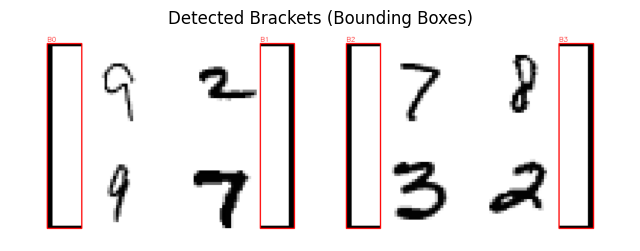

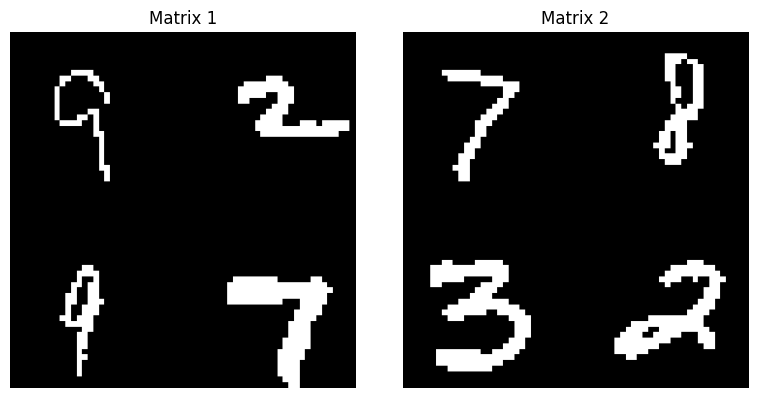

curr area 17280
curr area 7290
curr area 9990
curr area 9045
Total digit candidates found for matrix 1: 4
curr area 16335
curr area 16470
curr area 12690
curr area 8235
Total digit candidates found for matrix 2: 4


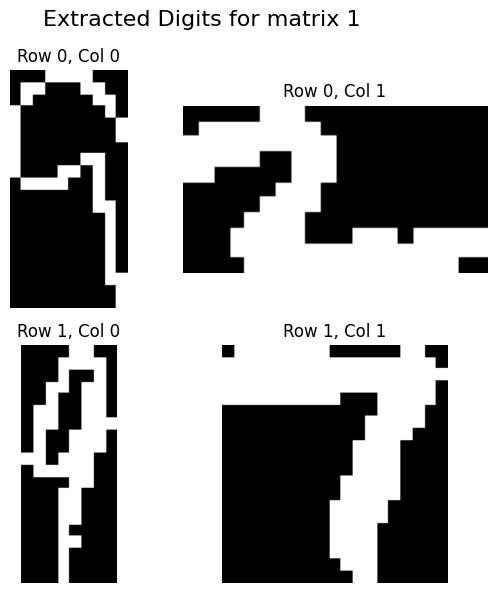

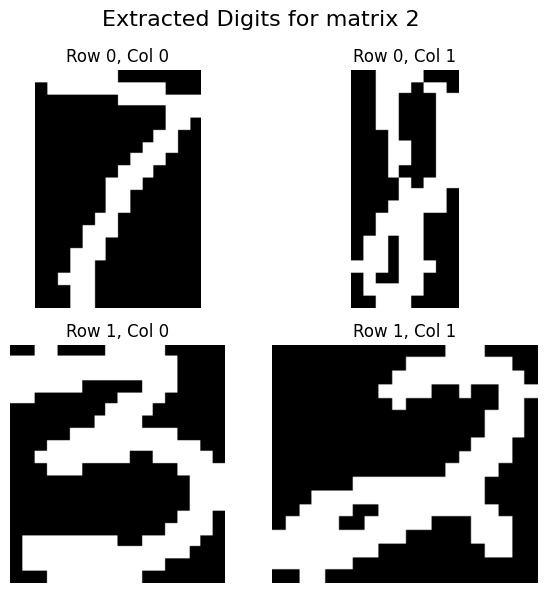

In [74]:
img = cv2.imread('MNIST_dataset/test/images/2x2_0.png', cv2.IMREAD_GRAYSCALE)
matrix1, matrix2 = image_segmentation(img)
digit_contours_1 = find_digits(matrix1, 1)
digit_contours_2 = find_digits(matrix2, 2)
#
digits_1 = group_contours_by_rows(digit_contours_1, matrix1, 1, 150)
digits_2 = group_contours_by_rows(digit_contours_2, matrix2, 2, 150)
#